In [ ]:
# (C) Copyright IBM Corp. 2019, 2020, 2021, 2022.

#    Licensed under the Apache License, Version 2.0 (the "License");
#    you may not use this file except in compliance with the License.
#    You may obtain a copy of the License at

#           http://www.apache.org/licenses/LICENSE-2.0

#     Unless required by applicable law or agreed to in writing, software
#     distributed under the License is distributed on an "AS IS" BASIS,
#     WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
#     See the License for the specific language governing permissions and
#     limitations under the License.


In [16]:
import warnings
import os
import time
with warnings.catch_warnings():
    
    from scipy.integrate import odeint
    import matplotlib.pyplot as plt
    from matplotlib.colors import Normalize
    import numpy as np
  
    from simulai.regression import OpInf
    from simulai.math.integration import RK4, LSODA, FunctionWrapper, ClassWrapper
    from simulai.metrics import LyapunovUnits
    from simulai.math.differentiation import CollocationDerivative

Lorenz 96 is an extension of the classical Lorenz 63 system for $N$ discrete variables. Lorenz 96 models the time evolution of an atmospheric variable spatially discretized over a single latitude.

$$
\frac{d\mathbf{x}_j}{dt} = (\mathbf{x}_{j+1} - \mathbf{x}_{j-2})\mathbf{x}_{j-1} - \mathbf{x}_j + F, \,\, j \in [0, N], \,\, N = 50
$$

In [2]:
def NRMSE(exact, approximated):
    return np.sqrt(np.mean(np.square(exact - approximated)/exact.std(axis=0)**2, axis=1))

In [3]:
def NRSE(exact, approximated):
    return np.sqrt(np.square(exact - approximated)/exact.std(axis=0)**2)

In [4]:
save_path = '/tmp'
tol = 0.5
# These are our constants
N = 50 # Number of variables
F = 8 # Forcing
raw_init = False
differentiation = 'spline'

label = f"n_{N}_F_{F}"

if F==8:
    lambda_1 = 1.68
else:
    lambda_1 = 2.27
    
T_lambda_1 = 1/lambda_1

In [5]:
def Lorenz96(x, t):
    """Lorenz 96 model with constant forcing"""
    # Setting up vector
    d = np.zeros(N)
    # Loops over indices (with operations and Python underflow indexing handling edge cases)
    for i in range(N):
        d[i] = (x[(i + 1) % N] - x[i - 2]) * x[i - 1] - x[i] + F
    return d


x0 = F * np.ones(N)  # Initial state (equilibrium)
x0 += 0.01*np.random.rand(N)  # Add small perturbation to the first variable
 
dt = 0.01
t = np.arange(0.0, 2000.0, dt)
lorenz_data = odeint(Lorenz96, x0, t)[t>=1000]

diff = CollocationDerivative(config={})

derivative_lorenz_data = diff.solve(data=lorenz_data, x=t[t>=1000])

Performing Collocation Derivation.


In [6]:
n_steps = t[t>=1000].shape[0]
nt = int(0.5 * n_steps)
nt_test = n_steps - nt
t_test = t[t>=1000][nt:]
n_field = N

In [7]:
train_field = lorenz_data[:nt]  
train_field_derivative = derivative_lorenz_data[:nt]

test_field = lorenz_data[nt:] 
test_field_derivatives = derivative_lorenz_data[nt:]

In [8]:
lorenz_op = OpInf(bias_rescale=1, solver='pinv')
lorenz_op.fit(input_data=train_field, target_data=train_field_derivative)

Forcing terms are not being used.
The data matrices fits in memory.
Fitting process concluded.


In [9]:
print(f"A_hat: \n\n {np.array_str(lorenz_op.A_hat, precision=5, suppress_small=True)}\n")
print(f"H_hat: \n\n {np.array_str(lorenz_op.H_hat, precision=5, suppress_small=True)}\n")
print(f"c_hat: \n\n {np.array_str(lorenz_op.c_hat, precision=5, suppress_small=True)}\n")

A_hat: 

 [[-0.99999  0.       0.00001 ...  0.       0.      -0.     ]
 [-0.      -0.99999 -0.      ...  0.       0.      -0.     ]
 [-0.      -0.      -0.99999 ...  0.      -0.       0.     ]
 ...
 [ 0.      -0.      -0.      ... -0.99999 -0.       0.     ]
 [ 0.       0.      -0.      ... -0.      -0.99999  0.     ]
 [ 0.       0.      -0.      ...  0.      -0.00001 -0.99999]]

H_hat: 

 [[-0.  0. -0. ... -0. -1. -0.]
 [-0.  0.  1. ...  0. -0. -0.]
 [-0. -1. -0. ... -0.  0.  0.]
 ...
 [ 0. -0. -0. ... -0.  0. -0.]
 [-0.  0.  0. ... -0.  0. -0.]
 [-0.  0. -0. ... -0.  0. -0.]]

c_hat: 

 [[7.99998]
 [8.00001]
 [8.00004]
 [7.99992]
 [8.00002]
 [8.00003]
 [7.99998]
 [7.99997]
 [7.99997]
 [7.99999]
 [8.00002]
 [8.00001]
 [7.99994]
 [7.99998]
 [7.99999]
 [7.99998]
 [7.99998]
 [7.99999]
 [7.99999]
 [7.99997]
 [7.99996]
 [8.00001]
 [8.00003]
 [7.99999]
 [7.99997]
 [8.00002]
 [7.99999]
 [7.99996]
 [8.00001]
 [7.99996]
 [7.99999]
 [7.99998]
 [8.00003]
 [8.00001]
 [7.99997]
 [7.99998]
 [8.    

In [10]:
init_state = train_field[-1:]
estimated_field_derivatives = lorenz_op.eval(input_data=test_field)
tags = [fr'x_{i}' for i in range(n_field)]

Construcing jacobian tensor (It could be used during the time-integrations, but seemingly it is not).

In [11]:
lorenz_op.construct_K_op()

Time-integrating the trained model and visualizing the output.

In [12]:
# Using the derivatives surrogate for time-integrating
right_operator = ClassWrapper(lorenz_op)

solver = LSODA(right_operator)

initial_state = init_state[0]

initial_time = time.time()
estimated_field = solver.run(initial_state, t_test)
elapsed_time = time.time() - initial_time
print(f"Elapsed time for time-integrating: {elapsed_time} s")

Elapsed time for time-integrating: 33.391879081726074 s


Estimating the number of Lyapunov units for the extrapolation.

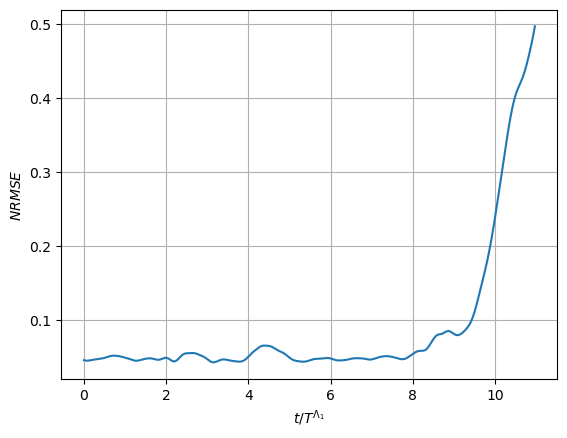

VPT is 10.970399999999954


In [13]:
nrmse = NRMSE(test_field, estimated_field)
nrmse_ = nrmse[nrmse<=tol]

time_ref = (t_test - t_test[0])/T_lambda_1
t_ref = time_ref[nrmse<=tol]
VPT = t_ref[-1]

plt.plot(t_ref, nrmse_)
plt.ylabel(r"$NRMSE$")
plt.xlabel(r"$t/T^{\Lambda_1}$")
plt.grid(True)
plt.savefig(os.path.join(save_path, f"nmrse_along_time_{label}.png"))
plt.show()

print(f"VPT is {VPT}")

nrse = NRSE(test_field, estimated_field)

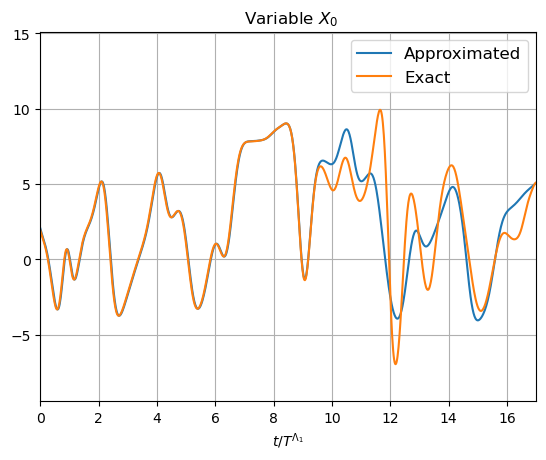

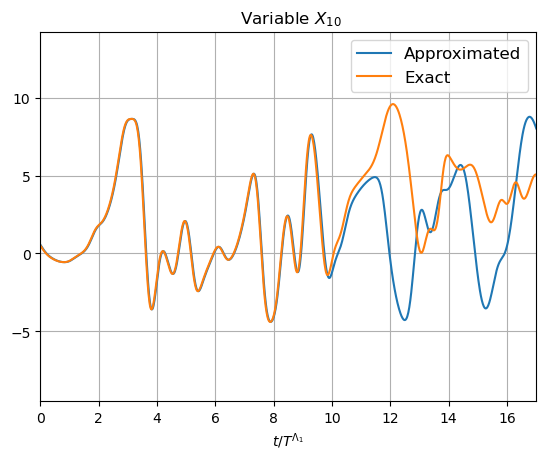

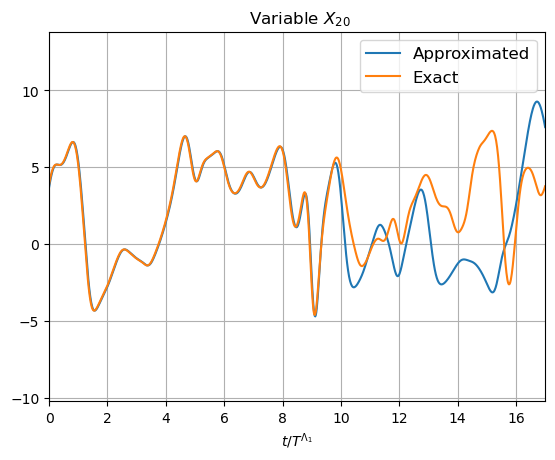

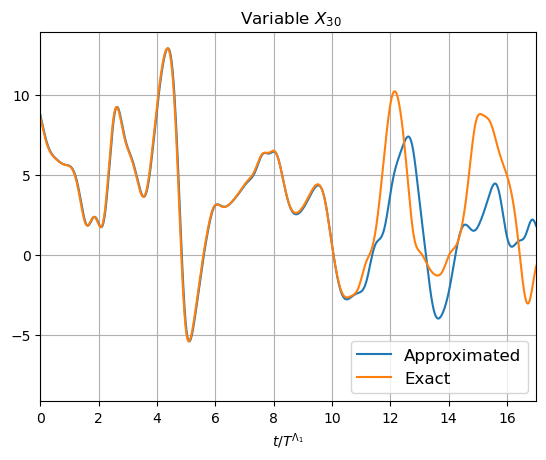

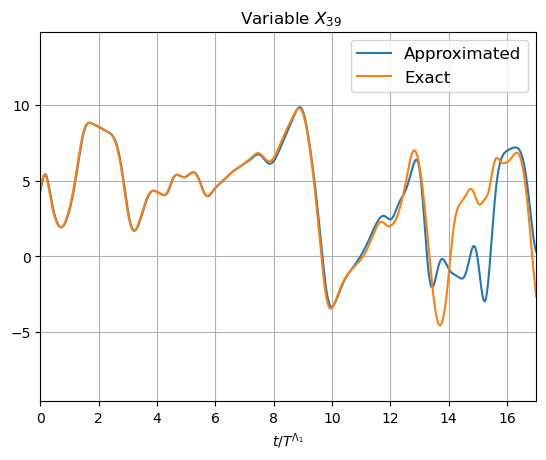

In [14]:
vars = [0, 10, 20, 30, 39]

for vv in vars:
    plt.plot(time_ref, estimated_field[:, vv], label="Approximated")
    plt.plot(time_ref, test_field[:, vv], label="Exact")
    plt.title(rf" Variable $X_{str({vv})}$")
    plt.xlabel(r"$t/T^{\Lambda_1}$")
    plt.xlim(0, 17)
    plt.grid(True)
    plt.legend(fontsize=12.)
    plt.savefig(os.path.join(save_path, f"evaluation_{vv}_{label}"))
    plt.show()

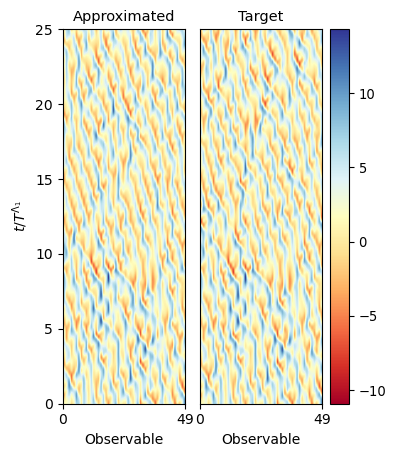

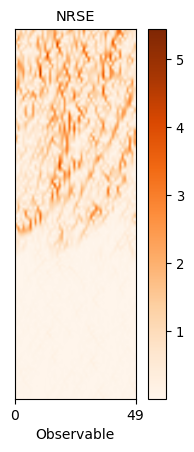

In [15]:
t_plot = time_ref
x_plot = np.arange(0, N)
aspect = 6
extent = x_plot.min(), x_plot.max(), t_plot.min(), t_plot.max()

color_norm = Normalize(vmin=test_field.min(), vmax=test_field.max())

fig, (ax1, ax2) = plt.subplots(ncols=2)

ax1.imshow(np.flip(estimated_field,axis=0), extent=extent, aspect=aspect, cmap='RdYlBu',
           interpolation='bilinear',
           norm=color_norm)

ax1.set_title("Approximated", fontsize=10.5)
ax1.set_xlabel("Observable")
ax1.set_ylabel(r"$t/T^{\Lambda_1}$")
ax1.set_xticks([0, 49])
ax1.set(ylim=(0, 25))

values2 = ax2.imshow(np.flip(test_field, axis=0), extent=extent, aspect=aspect, cmap='RdYlBu',
                    interpolation='bilinear',
                    norm=color_norm)

ax2.set_title("Target", fontsize=10.5)
ax2.set_xlabel("Observable")
ax2.set_xticks([0, 49])
ax2.set_yticks([])
ax2.set(ylim=(0, 25))

cbar1 = fig.colorbar(values2, ax=ax2)
fig.subplots_adjust(wspace=-0.1, bottom=.1, left=0.21, right=.7)

for t in cbar1.ax.get_yticklabels():
     t.set_fontsize(9.5)

plt.savefig(os.path.join(save_path, f"comparison_exact_predicted_2D_plot_{label}.png"))

plt.show()

fig1, ax3 = plt.subplots()
values3 = ax3.imshow(np.flip(nrse, axis=0), extent=extent, aspect=aspect,
           interpolation='bilinear',
           cmap="Oranges"
           )
ax3.set_title("NRSE", fontsize=10.5)
ax3.set_xlabel("Observable")
ax3.set_xticks([0, 49])
ax3.set_yticks([])
ax3.set(ylim=(0, 25))

cbar2 = fig.colorbar(values3, ax=ax3)
fig1.subplots_adjust(wspace=-.2, right=0.5, hspace=0)

for t in cbar2.ax.get_yticklabels():
     t.set_fontsize(9.5)
       
plt.savefig(os.path.join(save_path, f"no_number_nrse_2D_plot_{label}.png"))

plt.show()